In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import my_graph_tools as mgt
import numpy as np
import tensorflow as tf
import h5py
import sonnet as snt
import matplotlib.pyplot as plt
import os, sys, shutil

from importlib import reload
from progressbar import progressbar

%matplotlib inline

pi = np.pi
twopi = np.pi*2

Useful reference on using Sonnet:  
https://github.com/deepmind/sonnet/blob/v2/examples/mlp_on_mnist.ipynb  
DeepMind graph nn example on physics system:  
https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/physics.ipynb#scrollTo=toCQhJIM93en  
graph_nets InteractionNetwork class:  
https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork

### Init global parameters

In [5]:
runname = "secondring_t0.5v1.0l5_v2_gz"
inputfname = "nn_inputs/"+runname+".hdf5"
h5in = h5py.File(inputfname,'r')
N_NODE_FEAT = 4
N_EDGE_FEAT = 13
N_EDGE_FEAT_OG = 3
N_NODE_FEAT_OG = 3
N_NODE = h5in.attrs['n_nodes']
N_EDGE = h5in.attrs['n_edges']
NTG = h5in.attrs['nTG']
node_pos_np = h5in['node_coords'][:]
node_pos = mgt.get_node_coord_dict(h5in)
# covs = h5in['edge_node_covs'][:]
# nodestats = h5in['node_stats'][:]
# edgestats = h5in['edge_stats'][:]
senders = h5in['senders'][:]
receivers = h5in['receivers'][:]
h5in.close()

In [6]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [8]:
mgt.EdgeNodeCovariance(inputfname)

100% (2880 of 2880) |####################| Elapsed Time: 0:01:39 Time:  0:01:39
100% (2880 of 2880) |####################| Elapsed Time: 0:01:35 Time:  0:01:35
100% (2880 of 2880) |####################| Elapsed Time: 0:01:24 Time:  0:01:24
100% (2880 of 2880) |####################| Elapsed Time: 0:01:54 Time:  0:01:54
100% (2880 of 2880) |####################| Elapsed Time: 0:57:38 Time:  0:57:38
100% (2880 of 2880) |####################| Elapsed Time: 0:01:45 Time:  0:01:45
100% (2880 of 2880) |####################| Elapsed Time: 0:01:17 Time:  0:01:17


In [7]:
mgt.CalcMFactor(inputfname)

100% (2880 of 2880) |####################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (2880 of 2880) |####################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (2880 of 2880) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (2880 of 2880) |####################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (2880 of 2880) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (2880 of 2880) |####################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (2880 of 2880) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


In [25]:
reload(mgt)
h5in = h5py.File(inputfname,'r')
h5g = mgt.snap2graph(h5in,day=1,tg=72,normalize=False)
h5g_tf = mgt.snap2graph(h5in,day=1,tg=72, use_tf=True)
h5in.close()

In [52]:
reload(mgt)
mgt.create_nn_inputset(inputfname)

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

nn_edge_features group already exists. Overwriting
nn_node_features group already exists. Overwriting
nn_glbl_features group already exists. Overwriting


100% (7 of 7) |##########################| Elapsed Time: 0:07:23 Time:  0:07:23
N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Creating normalized dataset
Normed features exist. Overwriting
Applying norm to feature sets


100% (7 of 7) |##########################| Elapsed Time: 0:03:49 Time:  0:03:49


In [41]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [67]:
h5in=h5py.File(inputfname,'a')
glbl_stats = h5in['glbl_stats']
try:
    del h5in['nn_glbl_features']
except:
    pass
glblgrp = h5in.create_group("nn_glbl_features")
og_glblgrp = h5in['glbl_features']
for d in progressbar(range(7)):
    for tg in range(NTG):
        snapstr="day"+str(d)+"tg"+str(tg)
        og_glbls = og_glblgrp[snapstr]
        normed_glbls = mgt.mynorm(og_glbls,glbl_stats[0,:],glbl_stats[1,:])
        glblgrp.create_dataset(snapstr,data=normed_glbls,
                               compression='gzip',compression_opts=6)
h5in.close()

100% (7 of 7) |##########################| Elapsed Time: 0:00:21 Time:  0:00:21


In [68]:
tf.reset_default_graph()
hiddensize = 16
nlayer = 1

h5in = h5py.File(inputfname,'r')
# edge_model_fn: a callable to perform per-edge computations, etc.
graphnet = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Sequential([snt.nets.MLP([hiddensize]*nlayer),
                                          snt.Linear(output_size=N_EDGE_FEAT_OG)]),
    node_model_fn=lambda: snt.Sequential([snt.nets.MLP([hiddensize]*nlayer),
                                          snt.Linear(output_size=N_NODE_FEAT_OG)]),
    global_model_fn=lambda: mgt.timecrement(NTG),
    global_block_opt={"use_edges":False,"use_nodes":False})

input_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False)
lbl_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False)
output_graph = graphnet(input_graph)
# outnodes_0 = tf.rint(output_graph.nodes[:,0])
# outnodes = tf.concat((tf.reshape(outnodes_0,(N_NODE,1)),output_graph.nodes[:,1:]),axis=1)
# outedges_0 = tf.rint(output_graph.edges[:,0])
# outedges = tf.concat((tf.reshape(outedges_0,(N_EDGE,1)),output_graph.edges[:,1:]),axis=1)
# output_graph = output_graph.replace(nodes=outnodes, edges=outedges)

output_graph = output_graph.replace(edges=tf.concat((output_graph.edges,
                                                     input_graph.edges[:,3:6],
                                                     tf.multiply(output_graph.edges,input_graph.edges[0,3:6]),
                                                     tf.reshape(tf.multiply(output_graph.edges[:,0],
                                                                            output_graph.edges[:,1]),
                                                                (N_EDGE,1)
                                                               ),
                                                     
                                                    ),axis=1
                                                   ),
                                    nodes=tf.concat((output_graph.nodes,
                                                     tf.reshape(input_graph.nodes[:,3],(N_NODE,1))),
                                                    axis=1)
                                   )

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges[:,:3],
                                    predictions=output_graph.edges[:,:3])
opt = tf.train.AdamOptimizer(learning_rate=1e-4)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 10
Output nodes size: 4
Output globals size: 2


In [62]:
daytimes = mgt.get_daytimes()
np.random.shuffle(daytimes)

In [71]:
losses = []
sel_nodes_out, sel_nodes_input = [], []

nstep = 10000
mydays_inp = [6,6,6,6,0,0,0,0,0,0,0,0,0][7:]
mytgs_inp = [140,141,142,143,0,1,2,3,4,5,6,7,8][7:]
mydays_lbl = [6,6,6,0,0,0,0,0,0,0,0,0,0][7:]
mytgs_lbl = [141,142,143,0,1,2,3,4,5,6,7,8,9][7:]
lbls, outputs = [], []
saver = tf.train.Saver()
ckptpath = "ckpts/graphnn_M1.ckpt"
with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nstep)):
            if i%(7*NTG)==0:
                np.random.shuffle(daytimes)

            daytime = daytimes[i%(7*NTG)]
            day = daytime[0]
            tg = daytime[1]
            lbltg = (tg+1)%NTG
            lblday = (day+1)%7 if (lbltg==0) else day

#             tg = mytgs_inp[i%4]
#             day = mydays_inp[i%4]
#             lbltg = mytgs_lbl[i%4]
#             lblday = mydays_lbl[i%4]

            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
                        
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if i%50==0:
                losses.append(train_dict['loss'])
        saver.save(sess,ckptpath)

100% (10000 of 10000) |##################| Elapsed Time: 0:02:18 Time:  0:02:18


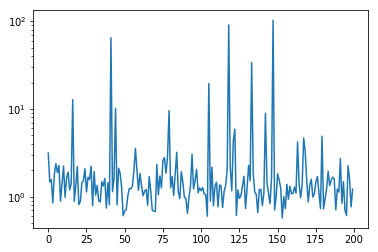

In [72]:
plt.semilogy(losses)

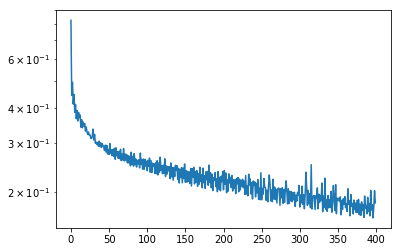

In [29]:
plt.semilogy(losses)

In [37]:
saver = tf.train.Saver()
days_inp = [1,1,1,1]
tgs_inp = [30,31,32,33]
days_lbl = [1,1,1,1]
tgs_lbl = [31,32,33,34]
nsnap = 4
inps, lbls, outs = [],[],[]
ckptpath = "ckpts/graphnn_M1.ckpt"

with h5py.File(inputfname,'r') as h5f:
    with tf.Session() as sess:
        saver.restore(sess,ckptpath)
        for i in range(nsnap):
            inp = mgt.snap2graph(h5f,day=days_inp[i],tg=tgs_inp[i])
            lbl = mgt.snap2graph(h5f,day=days_lbl[i],tg=tgs_lbl[i])
            out_d = sess.run({
                "out": output_graph
            }, feed_dict={
                input_graph: inp
            })
            out = mgt.unnorm_graph(out_d['out'],h5f['node_stats'],h5f['edge_stats'])
            out.nodes[:,0] = np.rint(out.nodes[:,0])
            outs.append(out)
            inps.append(mgt.snap2graph(h5f,day=days_inp[i],tg=tgs_inp[i],normalize=False))
            lbls.append(mgt.snap2graph(h5f,day=days_lbl[i],tg=tgs_lbl[i],normalize=False))

INFO:tensorflow:Restoring parameters from ckpts/graphnn_M1.ckpt


In [115]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [38]:
# Save graphs images
imgdir = 'images_tmp'
# if os.path.exists(imgdir):
#     shutil.rmtree(imgdir)
# os.makedirs(imgdir)

col_lims = [-1., nodestats[0,0]+nodestats[1,0], -1., edgestats[0,0]+edgestats[1,0]]
# col_lims = [0, 1., 0,1.]
for i in progressbar(range(3)):
    fig, ax = mgt.draw_graph(inps[i], node_pos, col_lims=col_lims, is_normed=False)
    _ = fig.savefig(imgdir+"/inp_"+str(i)+".pdf")
    plt.cla(); plt.clf()
    fig, ax = mgt.draw_graph(lbls[i], node_pos, col_lims=col_lims, is_normed=False)
    _ = fig.savefig(imgdir+"/lbl_"+str(i)+".pdf")
    plt.cla(); plt.clf()
    fig, ax = mgt.draw_graph(outs[i], node_pos, col_lims=col_lims, is_normed=False)
    _ = fig.savefig(imgdir+"/out_"+str(i)+".pdf")
    plt.cla(); plt.clf()

100% (3 of 3) |##########################| Elapsed Time: 0:02:06 Time:  0:02:06


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [8]:
lbl = lbls[0]
inp = inps[0]
out = outs[0]

In [80]:
# Edge 2665 in graphs_nx[0].edges is for 276->413
# When I make edgecol[2665] = 1, it goes to this connection
# So there is correspondance between placement of edgecol and graphs_nx.edge
# For some reason, this ordering of edges is different than our initial though.

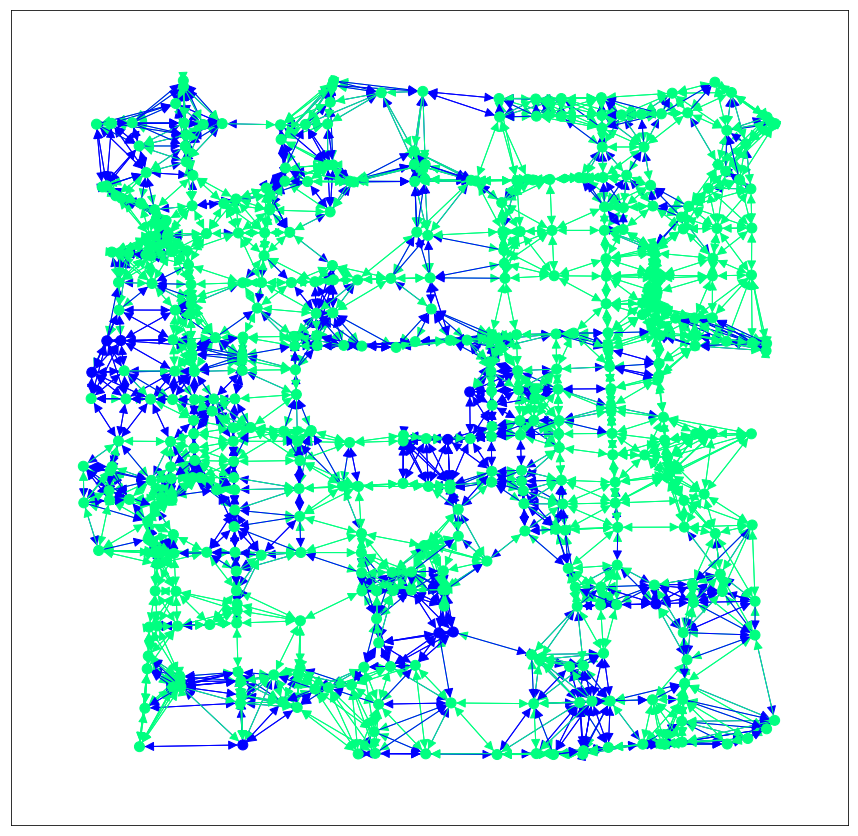

In [111]:
nodecols = lbl.nodes[:,0]

vmin,vmax = 0,1
e_vmin,e_vmax = 0,1

graphs_nx = utils_np.graphs_tuple_to_networkxs(lbl)
edgecols = np.zeros((N_EDGE,))
for i,e in enumerate(graphs_nx[0].edges):
    j = np.argwhere((senders==e[0]) & (receivers==e[1]))
    edgecols[i] = lbl.edges[j,0]

f,ax = plt.subplots(figsize=(15,15))
#nodesize=100
draw_ = mgt.nx.draw_networkx(graphs_nx[0],ax=ax,pos=node_pos,node_color=nodecols,
            edge_color=edgecols,node_size=100, with_labels=False,
            cmap=plt.cm.winter,edge_cmap=plt.cm.winter,
            vmin=vmin,vmax=vmax,edge_vmin=e_vmin,edge_vmax=e_vmax,
            arrowsize=10)

# drawn_edges = nx.draw_networkx_edge_labels(graphs_nx[0],ax=ax,pos=node_pos)
plt.show()

In [112]:
f.savefig("images_tmp/tmp.pdf")

In [55]:
reload(mgt)
tf.reset_default_graph()

NUM_PROC_STEP = 3

h5in = h5py.File(inputfname,'r')
input_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="input")
graphnet = mgt.EncodeProcessDecode(edge_output_size=3,
               node_output_size=N_NODE_FEAT, name="output")
output_graph_list = graphnet(input_graph,num_processing_steps=NUM_PROC_STEP)
out_pre = output_graph_list[-1]
output_graph = out_pre.replace(edges=tf.concat((out_pre.edges,
                                                     input_graph.edges[:,3:6],
                                                     tf.multiply(out_pre.edges,input_graph.edges[0,3:6]),
                                                     tf.reshape(tf.multiply(out_pre.edges[:,0],
                                                                            out_pre.edges[:,1]),
                                                                (N_EDGE,1))),
                                                     axis=1
                                                   )
                              )

lbl_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="label")

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges[:,:3],
                                    predictions=output_graph.edges[:,:3])

opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 10
Output nodes size: 3
Output globals size: 2


In [56]:
daytimes = np.zeros((7*NTG,2),dtype=int)
i = 0
for d in range(7):
    for tg in range(NTG):
        daytimes[i] = [d,tg]
        i+=1
np.random.shuffle(daytimes)

In [68]:
losses = []
out_graphs = []
nstep = 1000

mydays_inp = [6,6,6,6,0,0,0,0,0,0][4:]
mytgs_inp = [140,141,142,143,0,1,2,3,4,5][4:]
mydays_lbl = [6,6,6,0,0,0,0,0,0,0][4:]
mytgs_lbl = [141,142,143,0,1,2,3,4,5,6][4:]
nimg = len(mydays_inp)

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nstep)):
            if i%(7*NTG)==0:
                np.random.shuffle(daytimes)
#             tg = i%NTG
#             day = (i//NTG)%7
#             lbltg = (i+1)%NTG
#             lblday = (day+((tg+1)//NTG))%7
#             daytime = daytimes[i%(7*NTG)]
#             day = daytime[0]
#             tg = daytime[1]
#             lbltg = (tg+1)%NTG
#             lblday = (day+1)%7 if (lbltg==0) else day
            tg = mytgs_inp[i%nimg]
            day = mydays_inp[i%nimg]
            lbltg = mytgs_lbl[i%nimg]
            lblday = mydays_lbl[i%nimg]
            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if (i%50==0) or (i==(nstep-1)):
                out_graph = sess.run([output_graph],
                                    feed_dict={
                                        input_graph: graph,
                                        lbl_graph: lbl
                                    })
                out_graphs.append(out_graph[-1])
                losses.append(train_dict['loss'])


100% (1000 of 1000) |####################| Elapsed Time: 0:00:40 Time:  0:00:40


In [42]:
final_out = out_graphs[-1]
final_out = mgt.unnorm_graph(final_out, node_norms, edge_norms)
final_inp = mgt.unnorm_graph(graph,node_norms,edge_norms)
final_lbl = mgt.unnorm_graph(lbl,node_norms,edge_norms)

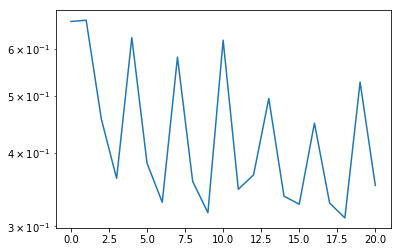

In [69]:
plt.semilogy(losses)

In [66]:
nodefeats = np.array([[1],[1],[1],[1]]).reshape(4,1)
sends = np.array([[0],[0],[1],[1],[2],[3]]).flatten()
reces = np.array([[1],[2],[2],[3],[3],[0]]).flatten()
edgefeats = np.zeros((6,1))
edgelbls = {}
for i in range(6):
    edgefeats[i] = i
    edgelbls.update({(sends[i],reces[i]):i})

dataD = {
    "nodes": nodefeats,
    "edges": edgefeats,
    "senders": sends,
    "receivers": reces,
    "globals": [[0]]
}
G = utils_np.data_dicts_to_graphs_tuple([dataD])

In [67]:
posn = {0:(0,0), 1:(0,1), 2:(1,1), 3:(1,0)}

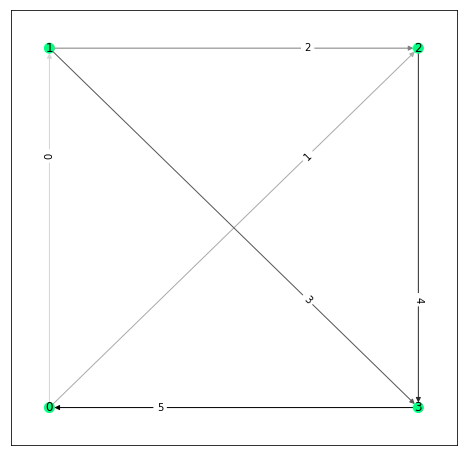

In [240]:
nodecols = G.nodes[:,0]
edgecols = G.edges[:,0]

vmin,vmax = 0,1
e_vmin,e_vmax = -1,5

graphs_nx = utils_np.graphs_tuple_to_networkxs(G)
f,ax = plt.subplots(figsize=(8,8))
#nodesize=100
draw_ = nx.draw_networkx(graphs_nx[0],ax=ax,pos=posn,node_color=nodecols,
            edge_color=edgecols,node_size=100,
            cmap=plt.cm.winter,edge_cmap=plt.cm.binary,
            vmin=vmin,vmax=vmax,edge_vmin=e_vmin,edge_vmax=e_vmax,
            arrowsize=10)
drawn_edges = nx.draw_networkx_edge_labels(graphs_nx[0],ax=ax,pos=posn,edge_labels=edgelbls,
                                           label_pos=0.3)

plt.show()

In [48]:
def make_set(h5_name):
    hf = h5py.File(h5_name,'r')
    ng = hf['node_features']
    ncars = np.zeros((7*mgt.NTG),dtype=np.int)
    daytimes = np.zeros((7*mgt.NTG,2),dtype=np.float)
    states = np.zeros((7*mgt.NTG,3),dtype=np.int)
    jamlist = np.arange(mgt.NTG//3-6,mgt.NTG//3+6)
    jamlist = np.append(jamlist,np.arange(2*mgt.NTG//3,2*mgt.NTG//3+12))
    i=0
    for d in progressbar(range(7)):
        for tg in progressbar(range(mgt.NTG)):
            nodes = ng["day"+str(d)+'tg'+str(tg)]
            ncars[i] = np.sum(nodes[:,0])
            daytimes[i] = [float(d)/6.,float(tg)/float(mgt.NTG-1)]
            if d in [0,6]:
                states[i,1] = 1
            elif tg in jamlist:
                states[i,2] = 1
            else:
                states[i,0] = 1
            i+=1
    hf.close()
    return daytimes, ncars, states
            

In [49]:
daytimes, ncars, states = make_set(inputfname)

100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [53]:
tf.reset_default_graph()

batchsize=36
mlp = snt.nets.MLP([16,16,3])
daytime_inp = tf.placeholder(np.double,shape=(batchsize,2))
daytime_lbl = tf.placeholder(np.double,shape=(batchsize,3))
lbl_arg = tf.arg_max(daytime_lbl,dimension=1)
logits = mlp(daytime_inp)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=lbl_arg,logits=logits))
# loss = tf.losses.mean_squared_error(labels=daytime_lbl,predictions=logits)
accuracy = tf.reduce_mean(tf.cast(tf.equal(lbl_arg,tf.arg_max(logits,dimension=1)),tf.float64))

opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
thelosses = []
thepreds = []
and_my_accs =  []
idxs = np.arange(len(daytimes))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in progressbar(range(8000)):
        np.random.shuffle(idxs)
        start = (i*batchsize)%NTG
        stop = start+batchsize
        grabs = idxs[start:stop]
        inp = daytimes[grabs]
        lbl = states[grabs]    
        
        train_dict = sess.run({
            "loss": loss,
            "_": loss_op,
            "logits": logits,
            "accuracy": accuracy,
        },     feed_dict={
            daytime_inp: inp,
            daytime_lbl: lbl
        })
        
        if i%100==0:
            and_my_accs.append(train_dict['accuracy'])
            thelosses.append(train_dict["loss"])
            thepreds.append(train_dict["logits"])


100% (12000 of 12000) |##################| Elapsed Time: 0:00:16 Time:  0:00:16
